In [1]:
import scipy.io as sio

mat_file = "../data/mpii_human_pose/mpii_human_pose.mat"
mat_data = sio.loadmat(mat_file, struct_as_record=False)
release_data = mat_data['RELEASE']

obj_rel = release_data[0,0] 
annolist = obj_rel.__dict__['annolist'] 
img_train = obj_rel.__dict__['img_train']
act = obj_rel.__dict__['act']

print(annolist.shape, img_train.shape, act.shape)

(1, 24987) (1, 24987) (24987, 1)


In [2]:
import numpy as np

keypoints_list = []
images_list = []
head_boxes_list = []

for ix in range(0, annolist.shape[1]):

    # Extract annotation for each image
    rect = annolist[0, ix].__dict__['annorect']

    if rect.shape[0] == 0:
        continue  # No annotation for this image
    
    obj_rect = rect[0, 0]

    # Extract head box
    head_box = []
    if 'x1' in obj_rect.__dict__ and 'y1' in obj_rect.__dict__ and 'x2' in obj_rect.__dict__ and 'y2' in obj_rect.__dict__:
        x1 = obj_rect.x1.item()
        y1 = obj_rect.y1.item()
        x2 = obj_rect.x2.item()
        y2 = obj_rect.y2.item()
        
        # Append head box to the list
        head_box.append([x1, y1, x2, y2])  # x1, y1, x2, y2
    else:
        continue  # Skip this image if no head box

    # Extract keypoints if available
    if 'annopoints' not in obj_rect.__dict__ or obj_rect.__dict__['annopoints'].shape[0] == 0:
        continue  # No keypoints for this image
    
    annopoints = obj_rect.__dict__['annopoints']
    obj_points = annopoints[0, 0]
    points = obj_points.__dict__['point']

    if points.shape[1] > 0:
        points_values = []
        for point in points[0, :]:
            x_value = point.x.item()  # Extract x-coordinate
            y_value = point.y.item()  # Extract y-coordinate

            points_values.append([x_value, y_value])  # Append point as [x, y]

        
        if len(points_values) == 16:
            # Append to the lists
            keypoints_list.append(points_values)
            head_boxes_list.append(head_box[0])  # We only store one head box for each image

            # Store corresponding image
            image = annolist[0, ix].__dict__['image'][0, 0].__dict__['name'][0]
            images_list.append(image)

# Convert lists to numpy arrays

# id - joint id (0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - \ 
    # head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)
keypoints_array = np.array(keypoints_list, dtype=np.float32)
images_array = np.array(images_list, dtype=object)
head_boxes_array = np.array(head_boxes_list, dtype=np.float32)

# Debugging outputs
print(f"Total images: {images_array.shape[0]}")
print(f"Total images with keypoints: {keypoints_array.shape[0]}")
print(f"Total bounding boxes: {head_boxes_array.shape[0]}")

print(keypoints_array.shape, images_array.shape, head_boxes_array.shape)


Total images: 11232
Total images with keypoints: 11232
Total bounding boxes: 11232
(11232, 16, 2) (11232,) (11232, 4)


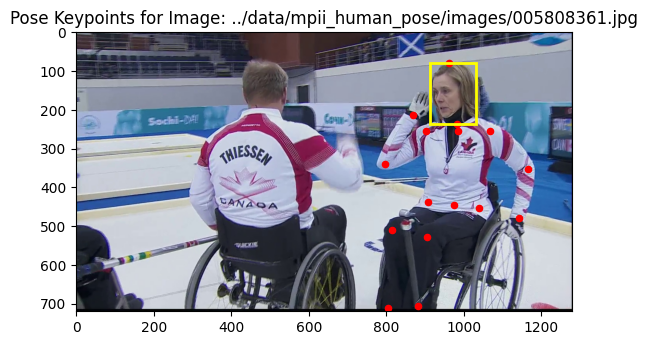

In [3]:
import cv2
import matplotlib.pyplot as plt
import os

# Test index
index = 1
image_filename = images_array[index] 
keypoints = keypoints_array[index]
head_box = head_boxes_array[index] 

# Construct the image path based on the filename and the folder where the images are stored
image_path = os.path.join('../data/mpii_human_pose/images/', image_filename)  

# Load the image using OpenCV
img = cv2.imread(image_path)
original_height, original_width = img.shape[:2]

# Plot the image with keypoints
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display in matplotlib

# Loop over each joint and plot its (x, y) coordinates
for i in range(len(keypoints)):  
    x = keypoints[i][0]
    y = keypoints[i][1]
    plt.scatter(x, y, color='red', s=20)  # Plot the keypoints as red dots

# Draw the head box (top-left and bottom-right corners)
x1, y1, x2, y2 = head_box
plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='yellow', linewidth=2))

plt.title(f'Pose Keypoints for Image: {image_path}')
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import torch

train_images, val_images, train_keypoints, val_keypoints = train_test_split(
    images_array, keypoints_array, test_size=0.2, random_state=42
)


class KeypointDataset(Dataset):
    def __init__(self, image_paths, keypoints, resize_to=256):
        """
        Initialize the KeypointDataset.

        Args:
            image_paths (list): List of image file paths.
            keypoints (list): List of keypoints corresponding to the images.
            resize_to (int): Target size for resizing the images (default: 256).
        """
        self.image_paths = image_paths
        self.keypoints = keypoints
        self.resize_to = resize_to

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filename = self.image_paths[idx]
        keypoints = self.keypoints[idx]

        # Load and preprocess the image with padding
        image_path = os.path.join('../data/mpii_human_pose/images/', image_filename)
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get original dimensions
        h, w, _ = image.shape
        scale = self.resize_to / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)

        # Resize image while keeping aspect ratio
        resized_image = cv2.resize(image, (new_w, new_h))

        # Calculate padding
        pad_top = (self.resize_to - new_h) // 2
        pad_bottom = self.resize_to - new_h - pad_top
        pad_left = (self.resize_to - new_w) // 2
        pad_right = self.resize_to - new_w - pad_left

        # Add padding
        padded_image = cv2.copyMakeBorder(
            resized_image, pad_top, pad_bottom, pad_left, pad_right,
            borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )

        # Rescale keypoints
        keypoints = keypoints * [scale, scale]  # Scale to resized dimensions
        keypoints += [pad_left, pad_top]  # Adjust for padding

        # Normalize keypoints to range [0, 1] relative to the padded image size
        keypoints /= [self.resize_to, self.resize_to]

        # Normalize and convert image to tensor
        image_tensor = torch.tensor(padded_image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32)

        return image_tensor, keypoints_tensor


# Initialize datasets and dataloaders with dynamic resizing
resize_to = 256  # You can change this value to your desired size
train_dataset = KeypointDataset(train_images, train_keypoints, resize_to=resize_to)
val_dataset = KeypointDataset(val_images, val_keypoints, resize_to=resize_to)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [5]:
from torch import nn
from torch import optim

class KeypointModel(nn.Module):
    def __init__(self, num_keypoints=16, input_size=256):
        super(KeypointModel, self).__init__()

        self.input_size = input_size

        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # Dynamically calculate the size of the feature map after convolution
        # Each MaxPool2d reduces the size by a factor of 2
        feature_map_size = input_size // (2 ** 3)  # 3 maxpool layers, each reducing size by 2

        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * feature_map_size * feature_map_size, 512), nn.ReLU(),
            nn.Linear(512, num_keypoints * 2)  # Predict x, y coordinates for each keypoint
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = self.conv_layers(x)
        # Pass through the fully connected layers
        return self.fc_layers(x)

# Create the model with the desired input size
resize_to = 256  # Or 128, depending on your input size
model = KeypointModel(input_size=resize_to)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()


In [6]:
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize running loss for the epoch

    for i, (images, keypoints) in enumerate(train_dataloader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, keypoints.view(-1, 16 * 2))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Print progress for every batch
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    # Print average epoch loss
    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

Epoch [1/1], Batch [1/281], Loss: 0.2667
Epoch [1/1], Batch [2/281], Loss: 11.4341
Epoch [1/1], Batch [3/281], Loss: 0.0894
Epoch [1/1], Batch [4/281], Loss: 0.4445
Epoch [1/1], Batch [5/281], Loss: 0.3332
Epoch [1/1], Batch [6/281], Loss: 0.2357
Epoch [1/1], Batch [7/281], Loss: 0.2272
Epoch [1/1], Batch [8/281], Loss: 0.1924
Epoch [1/1], Batch [9/281], Loss: 0.1820
Epoch [1/1], Batch [10/281], Loss: 0.1270
Epoch [1/1], Batch [11/281], Loss: 0.1041
Epoch [1/1], Batch [12/281], Loss: 0.0722
Epoch [1/1], Batch [13/281], Loss: 0.0578
Epoch [1/1], Batch [14/281], Loss: 0.0665
Epoch [1/1], Batch [15/281], Loss: 0.0354
Epoch [1/1], Batch [16/281], Loss: 0.0213
Epoch [1/1], Batch [17/281], Loss: 0.0164
Epoch [1/1], Batch [18/281], Loss: 0.0302
Epoch [1/1], Batch [19/281], Loss: 0.0279
Epoch [1/1], Batch [20/281], Loss: 0.0202
Epoch [1/1], Batch [21/281], Loss: 0.0160
Epoch [1/1], Batch [22/281], Loss: 0.0295
Epoch [1/1], Batch [23/281], Loss: 0.0310
Epoch [1/1], Batch [24/281], Loss: 0.0328


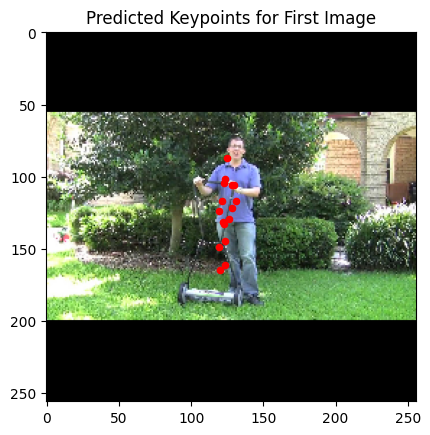

(32, 16, 2)


In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get one batch of data from the test_loader
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    images, keypoints = next(iter(val_dataloader))  # Get a batch of images and keypoints

# Move the image tensor to the same device as the model (if you're using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)
model = model.to(device)

# Predict keypoints for the batch
outputs = model(images)

# Detach the tensor from the computation graph and convert to numpy
predicted_keypoints = outputs.detach().view(images.size(0), -1, 2).cpu().numpy()

# Denormalize the predicted keypoints to the original image size
# Assuming keypoints were normalized based on 256x256, scale them back:
predicted_keypoints[:, :, 0] = predicted_keypoints[:, :, 0] * 256  # x-coordinate
predicted_keypoints[:, :, 1] = predicted_keypoints[:, :, 1] * 256  # y-coordinate

# Visualize the predicted keypoints for the first image in the batch
target_batch_image = 0
image = images[target_batch_image].cpu().permute(1, 2, 0).numpy()  # Convert the tensor back to HWC format for plotting
plt.imshow(image)  # Display the image

# Plot the predicted keypoints for the first image
for x, y in predicted_keypoints[target_batch_image]:  # First image in the batch
    plt.scatter(x, y, color='red', s=20)  # Predicted keypoints in red

plt.title("Predicted Keypoints for First Image")
plt.show()

# Print the shape of the predicted keypoints for debugging
print(predicted_keypoints.shape)  # Should print (batch_size, num_keypoints, 2)